# Week 6 HW

## Question 1
Implement the stochastic inventory control model in CVXPY with the following data.

(a) Demand $d$ can take 5 values: $d_1 = 10$, $d_2 = 20$, $d_3 = 30$, $d_4 = 40$, $d_5 = 50$, with probability $p_1 = 0.1$, $p_2 = 0.15$, $p_3 = 0.3$, $p_4 = 0.25$, $p_5 = 0.2$, respectively.

(b) Unit cost $c = 10$, retail price $r = 15$, discount price $s = 5$.

(c) Production capacity $\bar{x} = 75$.

#### Solution
The information above indicates there are **5** scenarios.  Therefore we will have 11 total variables (*1 for the 1st stage and 10 for the second stage.)*

In [2]:
import cvxpy as cp
import numpy as np

# given values
n = 5 # scenario count

d = np.array([10., 20., 30., 40., 50.])
p = np.array([0.1, .15, .30, .25, 0.2])
c = 10.
r = 15.
s = 5.
xbar = 75.

#lp variables
x = cp.Variable()
y = cp.Variable(n,1)
z = cp.Variable(n,1)

#problem setup
objective = cp.Minimize(c*x + p*(-r*y-s*z))
constraints = [x >= 0., x <= xbar, y >= 0., y <= d, z >= 0., -x + y + z <= 0.]

#solve
prob = cp.Problem(objective, constraints)
result = prob.solve()

#output results
print('The problem status is', prob.status)
print('The objective value is', round(result, 2))
print('The production quanity is', round(x.value,2))
print('The retail qty for each scenario is', [round(yy[0,0],2) for yy in y.value])
print('The sale qty for each scenario is', [round(zz[0,0], 2) for zz in z.value])

The problem status is optimal
The objective value is -115.0
The production quanity is 30.0
The retail qty for each scenario is [10.0, 20.0, 30.0, 30.0, 30.0]
The sale qty for each scenario is [20.0, 10.0, 0.0, 0.0, 0.0]


## Question 2
Given a set of training data...build the classifier using the absolute deviation regression (ADR).

#### (a) Is the objective function of (ADR) a convex function in β0, . . . , βn?
ADR is convex becuase it is a sum of convex functions.

#### (b) Write a linear programming reformulation of (ADR).
In the given data, the X array contains 2 features with 100 observations.  Therefore we need 3 variables $\beta_0$, $\beta_1$, and $\beta_2$. We also need 100 variables to support the LP formulation.

$\begin{aligned}
\text{min}_{\beta_0, \beta_1, \beta_2} \sum_{i=0}^{100} z_i \\
\text{s.t.} & \beta_0 + \sum_{j=1}^2 x_{ij}\beta_j - y_i \le z_i \forall i \in \{1,2,...,100\} \\
& \beta_0 + \sum_{j=1}^2 x_{ij}\beta_j - y_i \ge -z_i \forall i \in \{1,2,...,100\}
\end{aligned}$

#### (c) Code your LP reformulation of (ADR) in CVXPY, using the data file provided.
I ended up with 2 implementations.  The first is a direct implementation of the ADR. The other is the LP formulation.  Both yield the same result.

In [5]:
# direct implementation of ADR

import numpy as np

# load the file data (I created these files from the given file)
xs = np.loadtxt('x.dat')
#print(xs.shape)

ys = np.loadtxt('y.dat')
#print(ys.shape)

#lp variables
x = cp.Variable(3,1)
ones = np.ones([xs.shape[0], 1])
A = np.hstack([ones, xs])
#print(A)

#problem setup
objective = cp.Minimize(cp.sum_entries(cp.abs(ys - A*x)))
constraints = None

#solve
prob = cp.Problem(objective, constraints)
result = prob.solve()

#output results
print('The problem status is', prob.status)
print('The objective value is', round(result, 2))

params = [xx[0,0] for xx in x.value]
print('The hyperplane parameters are', [round(xx,4) for xx in params])

The problem status is optimal
The objective value is 26.52
The hyperplane parameters are [0.4036, 0.185, -0.1995]


In [6]:
# lp formulation

m = xs.shape[1] + 1
n = xs.shape[0]
b = cp.Variable(m, 1)
z = cp.Variable(n, 1)

ones = np.ones([n, 1])
A = np.hstack([ones, xs])

#problem setup
objective = cp.Minimize(cp.sum_entries(z))
constraints = [A*b - ys <= z, A*b - ys >= -z]

#solve
prob = cp.Problem(objective, constraints)
result = prob.solve()

#output results
print('The problem status is', prob.status)
print('The objective value is', round(result, 2))
params = [bb[0,0] for bb in b.value]
print('The hyperplane parameters are', [round(bb,4) for bb in params])

The problem status is optimal
The objective value is 26.52
The hyperplane parameters are [0.4036, 0.185, -0.1995]


#### (d) Write a Python code to plot the data points and the hyperplane obtained from (ADR).

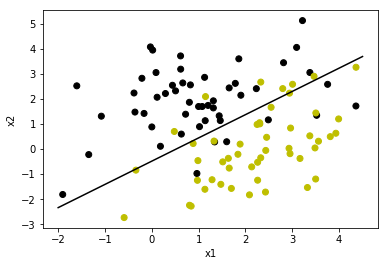

In [12]:
import matplotlib.pyplot as plt

plt.scatter(xs[:,0], xs[:,1], c=np.where(ys == 1, 'y', 'k'));
plt.xlabel("x1");
plt.ylabel("x2");

xx = np.linspace(-2, 4.5)
# plot b0 + b1*x1 + b2*x2 >= .5 which is x2 >= -b1/b2*x1 + (.5 - b0) / b2
a = -params[1] / params[2]
yy = a * xx + (.5 - params[0]) / params[2]
plt.plot(xx, yy, 'k-');
plt.show();